### ETAのシミュレーション
自動運転車が道路を走る際、

Strategic（運行前計画） => Tactical（運行時の計画） => Ground（細かいセンシングなど）

の3つのフェーズがある。本研究では2つ目のTacticalフェーズにおける、車両の間隔制御を目的とする。まず、Strategicフェーズでは、だいたい何時頃に何台が到着するかがわかる。それを受けてTacticalフェーズでは実際に道路に到着した車に走路の事前予約（以下、CWP Reservation）を行わせ、その通りに運行する。このシミュレーションはCWP Reservationのアルゴリズムについての研究である。

ここでは大きく3つのオブジェクトが登場する

1. CWPTable: 予約管理をするテーブル
2. Car: 到着時刻に基づきCWPTableに希望時刻を打刻する。
3. Simulation: 帯域密度や到着間隔の管理を行う。

In [1]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable
sys.path.append("../")
from utils import find_delta_v_list, find_delta_x_list

### パラメータ

- Global Density: 大域密度. 単位時間あたりの流入量
- Total_time_window: チケットを売っている時間の合計秒数
- window_size: チケット販売を分割する際の時間窓
- partition_num: チケット販売の分割数. 1だったら分割なしということ。

  ```Total_time_window = window_size * partition_num```
  が成立する。

In [2]:
# 初期設定（独立変数群）
CAR_NUM = 4 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
ORIFITH_LENGTH = 5 # 整流区間長さ. 最後のCWPのindexで指定。
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 100
V_MAX = 40

# ETAに関する設定
GLOBAL_TIME_WINDOW = 20  # Strategic Phaseでの時間幅
BATCH_NUM = 3
WINDOW_SIZE = (GLOBAL_TIME_WINDOW / BATCH_NUM)
DESIRED_TTC = 3 # 目標とする車間時間 [s]
DESIRED_SPEED = 25 # 目標とする車間時間 [s]


# ETA割り当てのアルゴリズム
"""
KISS: 基本的には車のdesiredに合わせる、最初のWaypointからTTCの分だけ空ける
CONTROLLED: 全体最適になるように調整
"""
ALGORITHM_LIST = ["KISS", "CONTROLLED", ]
ALGORITHM = ALGORITHM_LIST[1]

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 2 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }
rss_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, 
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":True,
  }
    

In [3]:
# 従属的に決まるもの
SIMULATION_STEPS = int(TOTAL_TIME / TIME_STEP)
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])

CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, \
              helly_params=helly_params, group_id=group_id, order_in_group=index)
              for index, time in enumerate(arrival_times)]
# for i in range(CAR_NUM):
cwp_table = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM, \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})


6.666666666666667


In [4]:
# 一旦雑にsimulation開始

for i in range(SIMULATION_STEPS):
    t = i * TIME_STEP
    delta_x_list = find_delta_x_list(CARS)
    delta_v_list = find_delta_v_list(CARS)

    for idx, car in enumerate(CARS):
        # この時間に到着する車がいれば打刻する
        if car.arrival_time >= t and car.arrival_time < t + TIME_STEP:
            print("idx={0}, 到着時刻={1}".format(idx, car.arrival_time))
            desired_list = car.create_desired_list(WAYPOINTS)
            # print(desired_list)
            is_valid = cwp_table.validate(desired_list)
            if is_valid:
                cwp_table.register(desired_list)
            else:
                calibration_info = {"desired_list":desired_list, "enter_speed": car.mean_speed, \
                                   "max_acc": car.helly_params["max_accel"],  "max_dec": car.helly_params["rear_brake_acc"]}
                calibrated_list = cwp_table.calibrate_list(**calibration_info)
                print(calibrated_list)
                cwp_table.register(calibrated_list)
            continue
        
        # そうでない車は普通に進む
        # delta_x = delta_x_list[idx]
        # delta_v = delta_v_list[idx]
        # speed = car.decide_speed(TIME_STEP, delta_x, delta_v)
        # print("idx:",idx, " speed:",speed)
        # print(delta_x_list)
        # print(delta_v_list)

        # delta_xとdelta_vの計算を移動前にやっているので実質pararellになっている
        # car.proceed(time_step=TIME_STEP)
        # car.record()
            
                


idx=0, 到着時刻=8.283457928543317
control
理想到着時刻 40.0
{'v_0': 20, 'v_lim': 40, 'v_exit': 25, 'a_max': 2, 'a_dec': 2, 't_0': 8.283457928543317, 't_end': 40.0, 'length': 1000.0}
{'is_possible': True, 'Reason': 'OK'}
ACD_MAX= 1112.4116828582673
CAC_MAX=786.66, course_length=1000.00
PROFILE:  ACD
m1の解=6.77
距離:999.71
[{'ACC': 2, 'duration': 6.77001953125, 'initial_speed': 20}, {'ACC': 0, 'duration': 20.676503008956683, 'initial_speed': 33.5400390625}, {'ACC': -2, 'duration': 4.27001953125, 'initial_speed': 33.5400390625}]

出口到達時刻:  40.011692318279515
出口到達時刻:  40.011692318279515
出口到達時刻:  40.011692318279515
出口到達時刻:  40.011692318279515
出口到達時刻:  40.011692318279515
[{'waypoint_idx': 0, 'x': 0.0, 'eta': 8.283457928543317, 'car_idx': 0, 'group_id': 0, 'order_in_group': 0}, {'waypoint_idx': 1, 'x': 200.0, 'eta': 15.61300110514517, 'car_idx': 0, 'group_id': 0, 'order_in_group': 0}, {'waypoint_idx': 2, 'x': 400.0, 'eta': 21.576023379129737, 'car_idx': 0, 'group_id': 0, 'order_in_group': 0}, {'waypoint_id

In [5]:
df = cwp_table.waypoint_table
print(df[df['car_idx'] == 0])
print(df[df['car_idx'] == 1])
print(CARS[1].arrival_time)

    waypoint_idx       x        eta  car_idx  group_id  order_in_group
0              0     0.0   8.283458        0         0               0
1              1   200.0  15.613001        0         0               0
2              2   400.0  21.576023        0         0               0
3              3   600.0  27.539046        0         0               0
4              4   800.0  33.502068        0         0               0
5              5  1000.0  40.011692        0         0               0
6              6  1200.0  48.011692        0         0               0
7              7  1400.0  48.011692        0         0               0
8              8  1600.0  48.011692        0         0               0
9              9  1800.0  48.011692        0         0               0
10            10  2000.0  48.011692        0         0               0
    waypoint_idx       x        eta  car_idx  group_id  order_in_group
0              0     0.0   9.829536        1         0               1
1     

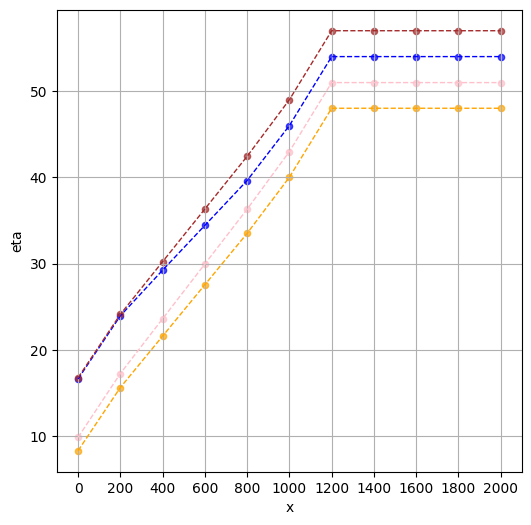

In [6]:
cwp_table.plot()

In [7]:
cwp_table.waypoints

[{'waypoint_idx': 0, 'x': 0.0},
 {'waypoint_idx': 1, 'x': 200.0},
 {'waypoint_idx': 2, 'x': 400.0},
 {'waypoint_idx': 3, 'x': 600.0},
 {'waypoint_idx': 4, 'x': 800.0},
 {'waypoint_idx': 5, 'x': 1000.0},
 {'waypoint_idx': 6, 'x': 1200.0},
 {'waypoint_idx': 7, 'x': 1400.0},
 {'waypoint_idx': 8, 'x': 1600.0},
 {'waypoint_idx': 9, 'x': 1800.0},
 {'waypoint_idx': 10, 'x': 2000.0}]

In [7]:
a = None
a[0]

TypeError: 'NoneType' object is not subscriptable